## Dataset
Data contains patients of at least 21-year-old patients of Pima Indian heritage in tabular format with the following variables:

+ Whether a patience has diabetes.
+ Number of times pregnant.
+ Plasma glucose concentration a 2 hours in an oral glucose tolerance test.
+ Diastolic blood pressure (mm Hg).
+ Triceps skin fold thickness (mm).
+ 2-Hour serum insulin (mu U/ml).
+ Body mass index (weight in kg/(height in m)$^2$).  
+ Diabetes pedigree function.
+ Age (years).

The necessary packages are downloaded, and the dataset is obtained in text format and converted to the dataframe with the following code:

In [1]:
# Download packages
import pandas as pd
import numpy as np
import optuna 
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.init as init
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split, SubsetRandomSampler
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve

# Set the ramdom state
np.random.seed(1865045)
torch.manual_seed(1865045)
if torch.cuda.is_available():
    torch.cuda.manual_seed(1865045)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Read the file
with open('diabetes_scale.txt', 'r') as f:
    lines = f.readlines()

# Split and parse the lines
data = []

# Default values
default_predictors = {i: None for i in range(1, 9)}  # using None for missing values

for line in lines:
    items = line.strip().split()
    outcome = int(items[0])
    predictors = default_predictors.copy()
    for item in items[1:]:
        col, value = item.split(':')
        predictors[int(col)] = float(value)
    data.append([outcome] + [predictors[i] for i in range(1, 9)])

# Create DataFrame with provided column names
column_names = ["outcome", "pregnancies", "glucose", "blood_pressure", "skin_thickness", "insulin", "bmi", "diabetes_pedigree_function", "age"]
diabetes = pd.DataFrame(data, columns=column_names)
diabetes

,outcome,pregnancies,glucose,blood_pressure,skin_thickness,insulin,bmi,diabetes_pedigree_function,age
0,-1,-0.294118,0.487437,0.180328,-0.292929,-1.000000,0.001490,-0.531170,-0.033333
1,1,-0.882353,-0.145729,0.081967,-0.414141,-1.000000,-0.207153,-0.766866,-0.666667
2,-1,-0.058824,0.839196,0.049180,-1.000000,-1.000000,-0.305514,-0.492741,-0.633333
3,1,-0.882353,-0.105528,0.081967,-0.535354,-0.777778,-0.162444,-0.923997,-1.000000
4,-1,-1.000000,0.376884,-0.344262,-0.292929,-0.602837,0.284650,0.887276,-0.600000
...,...,...,...,...,...,...,...,...,...
763,1,0.176471,0.015075,0.245902,-0.030303,-0.574468,-0.019374,-0.920581,0.400000
764,1,-0.764706,0.226131,0.147541,-0.454545,-1.000000,0.096870,-0.776260,-0.800000
765,1,-0.411765,0.216080,0.180328,-0.535354,-0.735225,-0.219076,-0.857387,-0.700000
766,-1,-0.882353,0.266332,-0.016393,-1.000000,-1.000000,-0.102832,-0.768574,-0.133333


The missing values are checked with the following code. 

In [2]:
missing_counts = diabetes.isna().sum()
print(missing_counts)

outcome                       0
pregnancies                   0
glucose                       0
blood_pressure                1
skin_thickness                0
insulin                       0
bmi                           0
diabetes_pedigree_function    0
age                           8
dtype: int64


Before imputation, the histograms of variables, containing missing value, are produced.

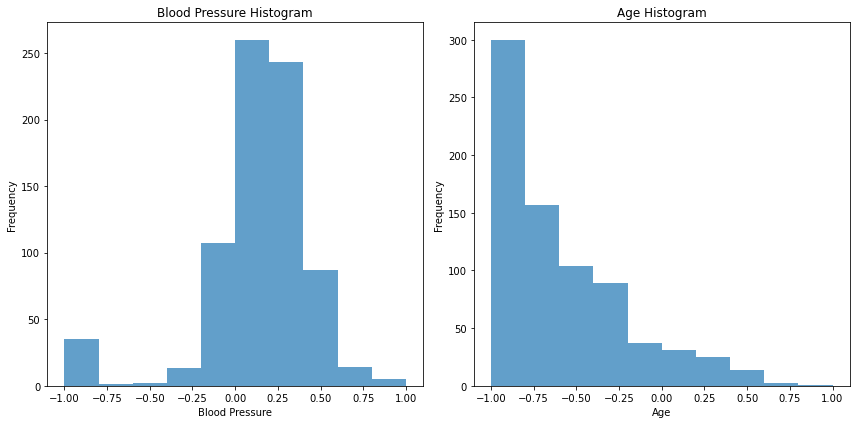

In [3]:
# Set up the figure and subplots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

# Plot the histogram for blood_pressure on the first subplot
axes[0].hist(diabetes['blood_pressure'], bins=10, alpha=0.7)
axes[0].set_title('Blood Pressure Histogram')
axes[0].set_xlabel('Blood Pressure')
axes[0].set_ylabel('Frequency')

# Plot the histogram for age on the second subplot
axes[1].hist(diabetes['age'], bins=10, alpha=0.7)
axes[1].set_title('Age Histogram')
axes[1].set_xlabel('Age')
axes[1].set_ylabel('Frequency')

plt.tight_layout()

# Display the plots
plt.show()


The missing values will be replaced with the median of each predictor, as the predictor is either skewed or has outliners

In [4]:
# Impute missing values with median
diabetes['blood_pressure'].fillna(diabetes['blood_pressure'].median(), inplace=True)
diabetes['age'].fillna(diabetes['age'].median(), inplace=True)

In [5]:
diabetes['outcome'] = diabetes['outcome'].replace({1: 0, -1: 1})

## Implementing MPL

Split the data with the outcome variable being stratified. 80% is the training data and the remaining 20 % will be testing data.

In [6]:
# Split the data
train_dataset, test_dataset = train_test_split(diabetes, test_size=0.2, random_state=1865045, stratify=diabetes['outcome'])

# Display the shape of the training and testing data
print(f"Training Data Shape: {train_dataset.shape}")
print(f"Testing Data Shape: {train_dataset.shape}")

Training Data Shape: (614, 9)
Testing Data Shape: (614, 9)


DiabetesDataset class is created to change the pandas dataframe to dataset in Pytorch

In [7]:
class DiabetesDataset(Dataset):
    def __init__(self, dataframe):
        self.data = dataframe

    def __len__(self):
        return len(self.data)
    # Obtain predictors and target variable for diabetes dataframe
    def __getitem__(self, idx):
        row = self.data.iloc[idx].values
        x = torch.tensor(row[1:], dtype=torch.float32)
        y = torch.tensor(row[0], dtype=torch.float32)
        return x, y

### MLP model

Class for MLP model is created with the room for hyper parameter tuning techniques, including hidden layer, activation function dropout, weight initialisation and batch normalisation. The number input layer will be fixed to reduce the computational burden. 

In [8]:
class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dims, activation_fn, dropout_rate, batch_norm, initialization):
        super(MLP, self).__init__()
        
        self.layers = nn.ModuleList()
        last_dim = input_dim
        self.batch_norm = batch_norm
        
        for hidden_dim in hidden_dims:
            self.layers.append(nn.Linear(last_dim, hidden_dim))
            if self.batch_norm:
                self.layers.append(nn.BatchNorm1d(hidden_dim))
            last_dim = hidden_dim
        
        self.out = nn.Linear(last_dim, 1)
        self.activation_fn = activation_fn
        self.dropout = nn.Dropout(dropout_rate)
        self.initialization = initialization

        # Apply initialization
        self.apply(self._initialize_weights)

    def forward(self, x):
        for layer in self.layers:
            if isinstance(layer, nn.Linear):
                x = self.activation_fn(layer(x))
                x = self.dropout(x)
            elif isinstance(layer, nn.BatchNorm1d):
                x = layer(x)
        x = self.out(x)
        return x
    
    # Apply different weight initialization
    def _initialize_weights(self, m):
        if isinstance(m, nn.Linear):
            if self.initialization == "xavier":
                init.xavier_uniform_(m.weight)
            elif self.initialization == "he":
                init.kaiming_uniform_(m.weight)
            elif self.initialization == "normal":
                init.normal_(m.weight, 0, 0.01)
            m.bias.data.fill_(0.01)


### Training fold

Define the function to measure binary cross entropy loss

In [9]:
def binary_cross_entropy_loss(outputs, labels):
    criterion = nn.BCEWithLogitsLoss()  # This combines sigmoid activation and binary cross entropy loss.
    return criterion(outputs, labels)

Define the function to create training fold and measure the loss

In [10]:
def train_fold(model, optimizer, train_loader, valid_loader, epochs=10):
    criterion = nn.BCEWithLogitsLoss()
    
    for epoch in range(epochs):
        model.train()
        for inputs, labels in train_loader:
            labels = labels.unsqueeze(1).float()
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

        model.eval()
        total_loss = 0.0
        for inputs, labels in valid_loader:
            labels = labels.unsqueeze(1).float()
            with torch.no_grad():
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                total_loss += loss.item()

    return total_loss / len(valid_loader)

Define objective function to minimise the loss of the training fold and apply hyperparameter tuning.

In [11]:
def objective(trial, activation_fn):
    # Hyperparameters to be tuned
    lr = trial.suggest_loguniform('lr', 1e-4, 1e-1)
    dropout_rate = trial.suggest_uniform('dropout_rate', 0, 0.5)
    batch_norm = trial.suggest_categorical('batch_norm', [True, False])
    initialization = trial.suggest_categorical('initialization', ["xavier", "he"])
    weight_decay = trial.suggest_loguniform('weight_decay', 1e-5, 1e-1)
    hidden_layer_size = trial.suggest_categorical('hidden_layer_size', [8, 16, 32, 64])

    fold_losses = []
    best_fold_loss = float('inf')  # Initialize the best fold loss to a high value.
    best_fold_model_state = None   # Initialize the model state.

    for train_idx, valid_idx in kf.split(dataset):
        train_subsampler = SubsetRandomSampler(train_idx)
        valid_subsampler = SubsetRandomSampler(valid_idx)

        train_loader = DataLoader(dataset, batch_size=32, sampler=train_subsampler)
        valid_loader = DataLoader(dataset, batch_size=32, sampler=valid_subsampler)

        model = MLP(8, [hidden_layer_size], activation_fn, dropout_rate, batch_norm, initialization)
        optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

        fold_loss = train_fold(model, optimizer, train_loader, valid_loader, epochs=10)
        fold_losses.append(fold_loss)

        # If current fold's model performs better than the previously saved models, update the best model state.
        if fold_loss < best_fold_loss:
            best_fold_loss = fold_loss
            best_fold_model_state = model.state_dict()

    avg_loss = sum(fold_losses) / len(fold_losses)
    
    # Store the best model state of current trial in the trial's user attributes.
    trial.set_user_attr("model_state", best_fold_model_state)

    return avg_loss


Train the model and apply the 5 fold cross validation. Best model for each activation functions and its variable are saved in variables to be further used.

In [12]:
kf = KFold(n_splits=5)
dataset = DiabetesDataset(train_dataset)  # Assuming your data is loaded in 'diabetes'

activation_fns = [torch.relu, torch.sigmoid, torch.tanh]
best_models = {}
best_params = {}

for activation_fn in activation_fns:
    study = optuna.create_study(direction='minimize')
    study.optimize(lambda trial: objective(trial, activation_fn), n_trials=100)

    if study.best_trial:
        best_models[activation_fn.__name__] = study.best_trial.user_attrs["model_state"]
        best_params[activation_fn.__name__] = study.best_params

print("Best models and parameters for each activation function:")
for act_fn in activation_fns:
    print(f"For {act_fn.__name__}:")
    print("Model State:", best_models[act_fn.__name__])
    print("Best Parameters:", best_params[act_fn.__name__])
    print("-----------------------------")

[I 2023-09-29 01:52:58,581] A new study created in memory with name: no-name-b2bbf43f-eb50-4b85-8094-0564ffb1ec14
C:\Users\ACER\AppData\Local\Temp\ipykernel_12380\2088363716.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-4, 1e-1)
C:\Users\ACER\AppData\Local\Temp\ipykernel_12380\2088363716.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0, 0.5)
C:\Users\ACER\AppData\Local\Temp\ipykernel_12380\2088363716.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..

[I 2023-09-29 01:54:56,528] Trial 23 finished with value: 0.4903026267886162 and parameters: {'lr': 0.020456251531740362, 'dropout_rate': 0.19501415182616752, 'batch_norm': True, 'initialization': 'he', 'weight_decay': 0.0018939060399099132, 'hidden_layer_size': 8}. Best is trial 10 with value: 0.48119664937257767.
[I 2023-09-29 01:55:02,080] Trial 24 finished with value: 0.4969576448202133 and parameters: {'lr': 0.04328139971130206, 'dropout_rate': 0.1844313825199957, 'batch_norm': True, 'initialization': 'xavier', 'weight_decay': 0.0015395919365536394, 'hidden_layer_size': 8}. Best is trial 10 with value: 0.48119664937257767.
[I 2023-09-29 01:55:06,938] Trial 25 finished with value: 0.5004779040813446 and parameters: {'lr': 0.005942702227009361, 'dropout_rate': 0.05540336806882845, 'batch_norm': True, 'initialization': 'xavier', 'weight_decay': 0.0042902594605766725, 'hidden_layer_size': 8}. Best is trial 10 with value: 0.48119664937257767.
[I 2023-09-29 01:55:11,694] Trial 26 finish

[I 2023-09-29 01:57:00,798] Trial 49 finished with value: 0.49338452368974683 and parameters: {'lr': 0.01402615718355797, 'dropout_rate': 0.16545553023826437, 'batch_norm': False, 'initialization': 'xavier', 'weight_decay': 0.0013181070260299928, 'hidden_layer_size': 8}. Best is trial 10 with value: 0.48119664937257767.
[I 2023-09-29 01:57:05,352] Trial 50 finished with value: 0.5101602062582969 and parameters: {'lr': 0.05868371956375386, 'dropout_rate': 0.19485295515789722, 'batch_norm': False, 'initialization': 'he', 'weight_decay': 0.0018791289149371936, 'hidden_layer_size': 32}. Best is trial 10 with value: 0.48119664937257767.
[I 2023-09-29 01:57:09,697] Trial 51 finished with value: 0.49445403963327406 and parameters: {'lr': 0.009655538929089873, 'dropout_rate': 0.13896883726948003, 'batch_norm': False, 'initialization': 'xavier', 'weight_decay': 0.002481662837971488, 'hidden_layer_size': 64}. Best is trial 10 with value: 0.48119664937257767.
[I 2023-09-29 01:57:14,267] Trial 52 

[I 2023-09-29 01:58:44,351] Trial 75 finished with value: 0.49246504455804824 and parameters: {'lr': 0.02361955582472316, 'dropout_rate': 0.11359843730181457, 'batch_norm': False, 'initialization': 'he', 'weight_decay': 0.0005091362554423557, 'hidden_layer_size': 8}. Best is trial 71 with value: 0.47968216985464096.
[I 2023-09-29 01:58:48,122] Trial 76 finished with value: 0.49336946904659273 and parameters: {'lr': 0.009644389520404585, 'dropout_rate': 0.1390954299500268, 'batch_norm': False, 'initialization': 'he', 'weight_decay': 0.0008252144162858255, 'hidden_layer_size': 8}. Best is trial 71 with value: 0.47968216985464096.
[I 2023-09-29 01:58:51,915] Trial 77 finished with value: 0.49680492132902143 and parameters: {'lr': 0.007041238888128882, 'dropout_rate': 0.12151231240552442, 'batch_norm': False, 'initialization': 'he', 'weight_decay': 0.0011518269841375084, 'hidden_layer_size': 8}. Best is trial 71 with value: 0.47968216985464096.
[I 2023-09-29 01:58:55,701] Trial 78 finished

[I 2023-09-29 02:00:28,892] Trial 1 finished with value: 0.4817501395940781 and parameters: {'lr': 0.04837897414927318, 'dropout_rate': 0.1636112962335129, 'batch_norm': True, 'initialization': 'he', 'weight_decay': 2.165827569523341e-05, 'hidden_layer_size': 16}. Best is trial 1 with value: 0.4817501395940781.
[I 2023-09-29 02:00:34,025] Trial 2 finished with value: 0.6582052946090698 and parameters: {'lr': 0.00037896614572018413, 'dropout_rate': 0.05624805109116715, 'batch_norm': True, 'initialization': 'xavier', 'weight_decay': 0.03261840497423151, 'hidden_layer_size': 8}. Best is trial 1 with value: 0.4817501395940781.
[I 2023-09-29 02:00:38,844] Trial 3 finished with value: 0.68278848528862 and parameters: {'lr': 0.0002919433772232266, 'dropout_rate': 0.3807837739002176, 'batch_norm': True, 'initialization': 'xavier', 'weight_decay': 2.564047339597592e-05, 'hidden_layer_size': 8}. Best is trial 1 with value: 0.4817501395940781.
[I 2023-09-29 02:00:43,895] Trial 4 finished with val

[I 2023-09-29 02:02:31,151] Trial 27 finished with value: 0.4944602087140083 and parameters: {'lr': 0.026760214399257316, 'dropout_rate': 0.05252697311868395, 'batch_norm': False, 'initialization': 'xavier', 'weight_decay': 0.00017397099857997174, 'hidden_layer_size': 16}. Best is trial 1 with value: 0.4817501395940781.
[I 2023-09-29 02:02:34,881] Trial 28 finished with value: 0.48925081491470335 and parameters: {'lr': 0.025982539015692446, 'dropout_rate': 0.15401010138321924, 'batch_norm': False, 'initialization': 'xavier', 'weight_decay': 3.920546820275283e-05, 'hidden_layer_size': 16}. Best is trial 1 with value: 0.4817501395940781.
[I 2023-09-29 02:02:39,539] Trial 29 finished with value: 0.5106227442622184 and parameters: {'lr': 0.05598030452487892, 'dropout_rate': 0.09164726299843383, 'batch_norm': False, 'initialization': 'xavier', 'weight_decay': 0.00018834709291820834, 'hidden_layer_size': 32}. Best is trial 1 with value: 0.4817501395940781.
[I 2023-09-29 02:02:43,358] Trial 3

[I 2023-09-29 02:04:16,244] Trial 53 finished with value: 0.49441023617982865 and parameters: {'lr': 0.054504157098609694, 'dropout_rate': 0.05899322842640231, 'batch_norm': False, 'initialization': 'xavier', 'weight_decay': 4.030702371794306e-05, 'hidden_layer_size': 16}. Best is trial 35 with value: 0.47735780030488967.
[I 2023-09-29 02:04:20,194] Trial 54 finished with value: 0.4964482136070728 and parameters: {'lr': 0.08057796028634373, 'dropout_rate': 0.02307544044486115, 'batch_norm': False, 'initialization': 'xavier', 'weight_decay': 8.443095677275444e-05, 'hidden_layer_size': 16}. Best is trial 35 with value: 0.47735780030488967.
[I 2023-09-29 02:04:24,107] Trial 55 finished with value: 0.4795980989933014 and parameters: {'lr': 0.03546838594178425, 'dropout_rate': 0.13754122716435255, 'batch_norm': False, 'initialization': 'xavier', 'weight_decay': 2.6425407233216338e-05, 'hidden_layer_size': 16}. Best is trial 35 with value: 0.47735780030488967.
[I 2023-09-29 02:04:29,479] Tri

[I 2023-09-29 02:06:12,351] Trial 79 finished with value: 0.4903064712882042 and parameters: {'lr': 0.08755625879054384, 'dropout_rate': 0.04232853465225136, 'batch_norm': False, 'initialization': 'xavier', 'weight_decay': 1.6277471188857937e-05, 'hidden_layer_size': 16}. Best is trial 35 with value: 0.47735780030488967.
[I 2023-09-29 02:06:18,186] Trial 80 finished with value: 0.5044499412178993 and parameters: {'lr': 0.06558831150908462, 'dropout_rate': 0.03031166920665554, 'batch_norm': True, 'initialization': 'he', 'weight_decay': 1.1784701551180516e-05, 'hidden_layer_size': 16}. Best is trial 35 with value: 0.47735780030488967.
[I 2023-09-29 02:06:22,027] Trial 81 finished with value: 0.4934591636061668 and parameters: {'lr': 0.04392221411605141, 'dropout_rate': 0.06817846110406503, 'batch_norm': False, 'initialization': 'xavier', 'weight_decay': 2.9457870092517817e-05, 'hidden_layer_size': 16}. Best is trial 35 with value: 0.47735780030488967.
[I 2023-09-29 02:06:25,795] Trial 82

[I 2023-09-29 02:08:02,393] Trial 5 finished with value: 0.4869022279977798 and parameters: {'lr': 0.02259143158156883, 'dropout_rate': 0.30399207907567766, 'batch_norm': True, 'initialization': 'he', 'weight_decay': 8.655572336441935e-05, 'hidden_layer_size': 64}. Best is trial 3 with value: 0.4710870862007141.
[I 2023-09-29 02:08:06,979] Trial 6 finished with value: 0.70917828977108 and parameters: {'lr': 0.00015090526700503316, 'dropout_rate': 0.37260120409627073, 'batch_norm': True, 'initialization': 'he', 'weight_decay': 0.024813274417813627, 'hidden_layer_size': 16}. Best is trial 3 with value: 0.4710870862007141.
[I 2023-09-29 02:08:11,730] Trial 7 finished with value: 0.48185442090034486 and parameters: {'lr': 0.03878468766046229, 'dropout_rate': 0.12884673832811122, 'batch_norm': True, 'initialization': 'he', 'weight_decay': 9.666371409940457e-05, 'hidden_layer_size': 32}. Best is trial 3 with value: 0.4710870862007141.
[I 2023-09-29 02:08:16,403] Trial 8 finished with value: 

[I 2023-09-29 02:09:50,210] Trial 31 finished with value: 0.478351517021656 and parameters: {'lr': 0.008948321909234057, 'dropout_rate': 0.08702340228411919, 'batch_norm': True, 'initialization': 'xavier', 'weight_decay': 0.00042236902809740555, 'hidden_layer_size': 16}. Best is trial 3 with value: 0.4710870862007141.
[I 2023-09-29 02:09:54,886] Trial 32 finished with value: 0.4816345453262329 and parameters: {'lr': 0.004304449374628, 'dropout_rate': 0.10883265466224692, 'batch_norm': True, 'initialization': 'xavier', 'weight_decay': 0.00021533844314128262, 'hidden_layer_size': 16}. Best is trial 3 with value: 0.4710870862007141.
[I 2023-09-29 02:09:59,544] Trial 33 finished with value: 0.47555237263441086 and parameters: {'lr': 0.008025309771319324, 'dropout_rate': 0.06687864956283938, 'batch_norm': True, 'initialization': 'xavier', 'weight_decay': 0.0005882750406606071, 'hidden_layer_size': 16}. Best is trial 3 with value: 0.4710870862007141.
[I 2023-09-29 02:10:04,293] Trial 34 fini

[I 2023-09-29 02:11:52,007] Trial 57 finished with value: 0.4840292975306511 and parameters: {'lr': 0.04190885539622487, 'dropout_rate': 0.09968113244407531, 'batch_norm': True, 'initialization': 'he', 'weight_decay': 0.0009458987629581527, 'hidden_layer_size': 16}. Best is trial 3 with value: 0.4710870862007141.
[I 2023-09-29 02:11:55,677] Trial 58 finished with value: 0.48101941794157027 and parameters: {'lr': 0.018861133064566295, 'dropout_rate': 0.16302979083985075, 'batch_norm': False, 'initialization': 'xavier', 'weight_decay': 0.0002581907925235297, 'hidden_layer_size': 16}. Best is trial 3 with value: 0.4710870862007141.
[I 2023-09-29 02:12:00,308] Trial 59 finished with value: 0.4914185807108879 and parameters: {'lr': 0.012862826642695516, 'dropout_rate': 0.04398849601496008, 'batch_norm': True, 'initialization': 'he', 'weight_decay': 0.0007686698074330086, 'hidden_layer_size': 64}. Best is trial 3 with value: 0.4710870862007141.
[I 2023-09-29 02:12:04,084] Trial 60 finished w

[I 2023-09-29 02:13:42,385] Trial 83 finished with value: 0.4799539133906364 and parameters: {'lr': 0.009911515259805612, 'dropout_rate': 0.07109606550193676, 'batch_norm': True, 'initialization': 'xavier', 'weight_decay': 0.0005227553660434381, 'hidden_layer_size': 16}. Best is trial 3 with value: 0.4710870862007141.
[I 2023-09-29 02:13:47,063] Trial 84 finished with value: 0.4803510457277298 and parameters: {'lr': 0.01570649401375828, 'dropout_rate': 0.08478898018718845, 'batch_norm': True, 'initialization': 'xavier', 'weight_decay': 8.6185935591509e-05, 'hidden_layer_size': 16}. Best is trial 3 with value: 0.4710870862007141.
[I 2023-09-29 02:13:51,746] Trial 85 finished with value: 0.4915069445967674 and parameters: {'lr': 0.022029983079229563, 'dropout_rate': 0.12342750496963974, 'batch_norm': True, 'initialization': 'xavier', 'weight_decay': 0.00021074826254515502, 'hidden_layer_size': 16}. Best is trial 3 with value: 0.4710870862007141.
[I 2023-09-29 02:13:56,473] Trial 86 finis

Best models and parameters for each activation function:
For relu:
Model State: OrderedDict([('layers.0.weight', tensor([[-8.3612e-01, -7.2430e-01,  5.8316e-01, -3.3091e-02, -2.2370e-02,
         -8.4362e-01, -6.5242e-01,  4.8213e-02],
        [-3.6442e-01, -8.2838e-01,  7.1203e-02, -6.2463e-02, -1.6621e-02,
         -5.0035e-01, -8.0928e-01, -3.1542e-01],
        [ 4.0820e-01,  2.0344e-01,  8.1889e-01,  3.4172e-02, -6.6785e-01,
          6.2859e-01,  3.2664e-01,  1.2129e-01],
        [ 2.0705e-01,  2.6086e-02, -1.5364e-01,  1.5690e-01,  4.9714e-01,
          1.6619e-01, -8.1281e-02, -3.7310e-02],
        [-2.9265e-04, -3.4398e-04,  1.6353e-05, -1.3536e-04, -6.8366e-04,
         -3.1294e-05,  4.3941e-04, -1.7086e-04],
        [-3.4735e-01, -1.1947e+00,  4.4523e-01,  1.3630e-01,  2.4523e-01,
         -3.3861e-01, -7.9610e-01, -4.9417e-01],
        [ 8.2367e-03, -2.5287e-02,  2.9994e-03,  1.0194e-02,  3.9866e-02,
          3.6492e-03,  3.9653e-02,  1.0741e-02],
        [-1.5517e-01,  1.4

### Result

Define functions

+ test_model:  function takes in a PyTorch model (model) and a dataloader (dataloader) to label probability of patient for being classified as class 1 (having diabetes)
+ get_accuracy: function takes output from the test_model() and evaluate accuracy with threshold of 0.5 for patient to be classified as class 1
+ get_confusion_matrix: function takes output from the test_model() and evaluate confusion matrix with threshold of 0.5
+ get_sensitivity: function takes output from get_confusion_matrix() and evaluate sensitivity
+ get_specificity: function takes output from get_confusion_matrix() and evaluate specificity
+ plot_roc_curve: function plots the ROC curve

In [13]:
def test_model(model, dataloader):
    model.eval()
    all_outputs = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels in dataloader:
            outputs = model(inputs)
            all_outputs.append(outputs)
            all_labels.append(labels)
    return torch.cat(all_outputs), torch.cat(all_labels)

def get_accuracy(outputs, labels, threshold=0.5):
    predicted = [1 if o > threshold else 0 for o in outputs]
    correct = sum(p == l for p, l in zip(predicted, labels))
    return correct / len(labels)

def get_confusion_matrix(outputs, labels, threshold=0.5):
    predicted = [1 if o > threshold else 0 for o in outputs]
    return confusion_matrix(labels, predicted)

def get_sensitivity(confusion_mtx):
    # Sensitivity or True Positive Rate: TP / (TP + FN)
    return confusion_mtx[1][1] / (confusion_mtx[1][1] + confusion_mtx[1][0])

def get_specificity(confusion_mtx):
    # Specificity or True Negative Rate: TN / (TN + FP)
    return confusion_mtx[0][0] / (confusion_mtx[0][0] + confusion_mtx[0][1])

def plot_roc_curve(outputs, labels):
    fpr, tpr, _ = roc_curve(labels, outputs)
    roc_auc = roc_auc_score(labels, outputs)

    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()

Evaluate the model for the training data.

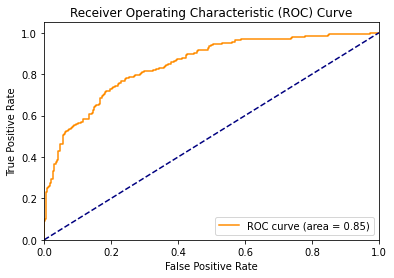


Evaluating for activation function: relu
Accuracy: 0.79
Sensitivity: 0.52
Specificity: 0.94
ROC AUC: 0.8453
Confusion Matrix:
[[374  26]
 [103 111]]


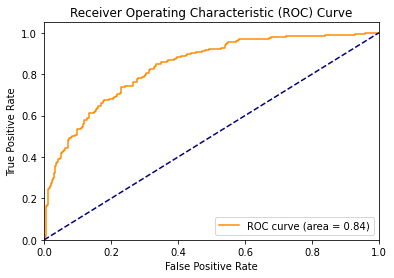


Evaluating for activation function: sigmoid
Accuracy: 0.76
Sensitivity: 0.37
Specificity: 0.96
ROC AUC: 0.8368
Confusion Matrix:
[[385  15]
 [135  79]]


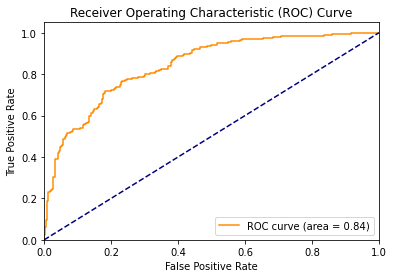


Evaluating for activation function: tanh
Accuracy: 0.78
Sensitivity: 0.47
Specificity: 0.94
ROC AUC: 0.8425
Confusion Matrix:
[[377  23]
 [113 101]]


In [21]:
# Mapping of activation functions
activation_fn_map = {
    'relu': torch.relu,
    'sigmoid': torch.sigmoid,
    'tanh': torch.tanh
}
train_loader = DataLoader(DiabetesDataset(train_dataset), batch_size=32)  # Replace with your test dataset

for act_fn_name, model_state in best_models.items():
    params = best_params[act_fn_name]

    # Instantiate the MLP
    model = MLP(
        input_dim=8,
        hidden_dims=[params['hidden_layer_size']],
        activation_fn=activation_fn_map[act_fn_name],
        dropout_rate=params['dropout_rate'],
        batch_norm=params['batch_norm'],
        initialization=params['initialization']
    )
    model.load_state_dict(model_state)

    # Evaluate
    outputs, labels = test_model(model, train_loader)
    
    accuracy = get_accuracy(outputs, labels)
    conf_mtx = get_confusion_matrix(outputs, labels)
    sensitivity = get_sensitivity(conf_mtx)
    specificity = get_specificity(conf_mtx)
    roc_auc = roc_auc_score(labels, outputs)
    
    # Plot ROC Curve
    plot_roc_curve(outputs, labels)

    print(f"\nEvaluating for activation function: {act_fn_name}")
    print(f"Accuracy: {accuracy:.2f}")
    print(f"Sensitivity: {sensitivity:.2f}")
    print(f"Specificity: {specificity:.2f}")
    print(f"ROC AUC: {roc_auc:.4f}")
    print(f"Confusion Matrix:\n{conf_mtx}")



Evaluate the model for the testing data.


Evaluating for activation function: relu
Accuracy: 0.79
Sensitivity: 0.50
Specificity: 0.94
ROC AUC: 0.85
Confusion Matrix:
[[94  6]
 [27 27]]


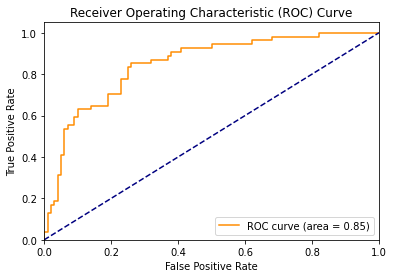


Evaluating for activation function: sigmoid
Accuracy: 0.70
Sensitivity: 0.24
Specificity: 0.95
ROC AUC: 0.85
Confusion Matrix:
[[95  5]
 [41 13]]


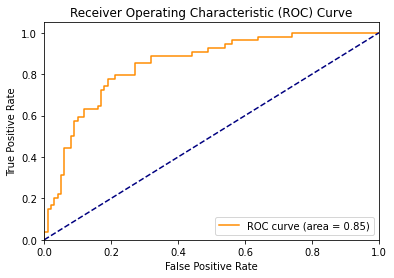


Evaluating for activation function: tanh
Accuracy: 0.75
Sensitivity: 0.41
Specificity: 0.93
ROC AUC: 0.84
Confusion Matrix:
[[93  7]
 [32 22]]


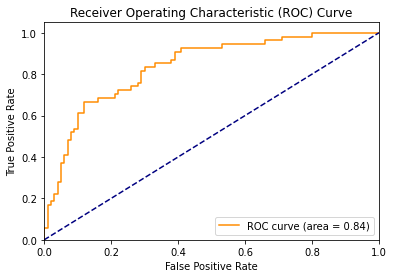

In [14]:
test_loader = DataLoader(DiabetesDataset(test_dataset), batch_size=32)  # Replace with your test dataset

for act_fn_name, model_state in best_models.items():
    params = best_params[act_fn_name]

    # Instantiate the MLP
    model = MLP(
        input_dim=8,
        hidden_dims=[params['hidden_layer_size']],
        activation_fn=activation_fn_map[act_fn_name],
        dropout_rate=params['dropout_rate'],
        batch_norm=params['batch_norm'],
        initialization=params['initialization']
    )
    model.load_state_dict(model_state)

    # Evaluate
    outputs, labels = test_model(model, test_loader)
    
    accuracy = get_accuracy(outputs, labels)
    conf_mtx = get_confusion_matrix(outputs, labels)
    sensitivity = get_sensitivity(conf_mtx)
    specificity = get_specificity(conf_mtx)
    roc_auc = roc_auc_score(labels, outputs)

    print(f"\nEvaluating for activation function: {act_fn_name}")
    print(f"Accuracy: {accuracy:.2f}")
    print(f"Sensitivity: {sensitivity:.2f}")
    print(f"Specificity: {specificity:.2f}")
    print(f"ROC AUC: {roc_auc:.2f}")
    print(f"Confusion Matrix:\n{conf_mtx}")

    # Plot ROC Curve
    plot_roc_curve(outputs, labels)
